<a href="https://colab.research.google.com/github/ADHIL-VENGAT/CE888-DataScience-and-Decision-making/blob/main/causal_inference_CE888_lab_4_COPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STEP 1 Packages**

In [1]:
!pip install econml

     |████████████████████████████████| 3.3 MB 7.4 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 356 kB 33.6 MB/s 
     |████████████████████████████████| 123 kB 48.8 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491661 sha256=c3a02fd68cf3c2c1a229fb202b8300daf01d4783c4b694986e74e3b975356a18
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**STEP 2.2 METRICS**

In [3]:
def abs_ate(effect_true, effect_pred):
    """
    Absolute error for the Average Treatment Effect (ATE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: absolute error on ATE
    """
    # YOUR CODE HERE
    return abs(sum(effect_true)/len(effect_true) - sum(effect_pred)/len(effect_pred))

def pehe(effect_true, effect_pred):
    """
    Precision in Estimating the Heterogeneous Treatment Effect (PEHE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: PEHE
    """
    # YOUR CODE HERE
    return np.sqrt(np.mean((effect_true - effect_pred)**2))

**Step 2.3 - data**

In [4]:
!wget https://github.com/dmachlanski/CE888_2022/raw/main/lab4/data/sodium_10k.npz

--2022-02-22 10:18:10--  https://github.com/dmachlanski/CE888_2022/raw/main/lab4/data/sodium_10k.npz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/sodium_10k.npz [following]
--2022-02-22 10:18:10--  https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/sodium_10k.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320962 (313K) [application/octet-stream]
Saving to: ‘sodium_10k.npz’

sodium_10k.npz      100%[===================>] 313.44K  --.-KB/s    in 0.02s   

2022-02-22 10:18:10 (14.3 MB/s) - ‘sodium_10k.npz’ saved [320962/320962]


In [5]:
data = np.load('sodium_10k.npz')

In [6]:
data.files

['x', 't', 'y', 'ite']

In [7]:
for f in data.files:
  print(f'{f}: {data[f].shape}')

x: (10000,)
t: (10000,)
y: (10000,)
ite: (10000,)


In [8]:
X = data['x'].reshape(-1, 1)
T = data['t'].reshape(-1, 1)
Y = data['y'].reshape(-1, 1)
ite = data['ite']

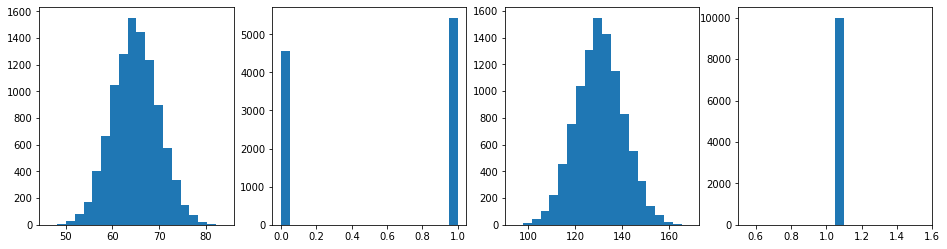

In [9]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
axs[3].hist(ite, bins=bins)
plt.show()

In [10]:
np.mean(ite)

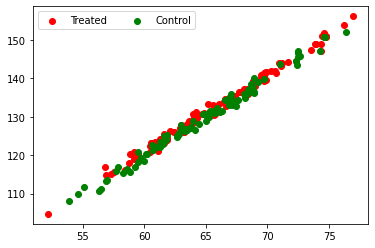

In [11]:
limit = 100
plt.scatter(X[T == 1][:limit], Y[T == 1][:limit], c = "r", label = "Treated")
plt.scatter(X[T == 0][:limit], Y[T == 0][:limit], c = "g", label = "Control")
plt.legend(ncol=2)

**Step 2.4 - data pre-processing**

In [12]:
x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(X, T, Y, ite, test_size=0.2)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

**Step 2.5 - training**

In [13]:
# Random Forest with default parameters.
rf = RandomForestRegressor()

# Train on the training data.
# In the supervised setting, our usual X here consists of X and T.
# The target is Y - the outcome.
# Input: [X, T], output: Y.
# Hint: use np.concatenate or np.hstack functions to merge X and T.

xt_train = np.concatenate([x_train, t_train], axis=1) # YOUR CODE HERE
rf.fit(xt_train, y_train.flatten())

# Predictions
# Note we set T to a specific value for ALL individuals.
# These are interventional distributions - P(Y|X, do(T=t)).

# Predict Y_0 given [X, 0]
# Hint: use np.zeros_like or np.zeros functions to get the zeros for all units.
# Hint 2: you still have to merge X and zeros (see training above).
xt0_test = np.concatenate([x_test, np.zeros_like(t_test)], axis=1)# YOUR CODE HERE
rf_y0_test = rf.predict(xt0_test)

# Predict Y_1 given [X, 1]
# Hint: use np.ones_like or np.ones functions to get the ones for all units.
# Hint 2: you still have to merge X and ones (see training above).
xt1_test = np.concatenate([x_test, np.ones_like(t_test)], axis=1) # YOUR CODE HERE
rf_y1_test = rf.predict(xt1_test)

# Compute ITEs
# ITE = Y_1 - Y_0
rf_te_test = rf_y1_test - rf_y0_test # YOUR CODE HERE

In [14]:
rf_te_test

array([ 2.27372672, -0.3134398 ,  1.81396055, ..., -0.78129622,
        0.63172215,  2.59655747])

**Random Forest with IPW**

In [15]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
  # Given ti and ptx values, compute the weights wi (see formula above):
  wi =  ti/(ptx)  +  (1 - ti)/(1 - (ptx))   # YOUR CODE HERE
  return wi

In [16]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()

rf_ipsw.fit(xt_train, y_train.flatten(), sample_weight= weights )

# Make predictions
rf_ipsw_y0_test = rf_ipsw.predict(xt0_test) # YOUR CODE HERE
rf_ipsw_y1_test = rf_ipsw.predict(xt1_test)# YOUR CODE HERE

# Compute ITEs
rf_ipsw_te_test = rf_ipsw_y1_test - rf_ipsw_y0_test # YOUR CODE HERE

In [17]:
rf_ipsw_te_test

array([ 2.23436741, -0.00686422,  1.86146911, ..., -0.80166325,
        0.52790703,  2.32996428])

**X-learner**

In [18]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train.flatten(), X=x_train)

xl_te_test = xl.effect(x_test)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


**Evaluation**

METRICS

In [24]:
# Error on ATE
# Use our 'abs_ate' function, true ITEs and predicted ITEs to get the measurements.
rf_ate_test = abs_ate(ite_test, rf_te_test) # YOUR CODE HERE
rf_ipsw_ate_test = abs_ate(ite_test, rf_ipsw_te_test)# YOUR CODE HERE
xl_ate_test = abs_ate(ite_test, xl_te_test)# YOUR CODE HERE

# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test =pehe(ite_test, rf_te_test) # YOUR CODE HERE
rf_ipsw_pehe_test = pehe(ite_test, rf_ipsw_te_test)# YOUR CODE HERE
xl_pehe_test =  pehe(ite_test, xl_te_test) # YOUR CODE HERE

In [25]:
results = []
results.append(['RF', rf_ate_test, rf_pehe_test])
results.append(['RF (IPW)', rf_ipsw_ate_test, rf_ipsw_pehe_test])
results.append(['XL', xl_ate_test, xl_pehe_test])

cols = ['Method', 'ATE test', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE test,PEHE test
0,RF,0.004355,0.997729
1,RF (IPW),0.005641,0.991939
2,XL,[0.019605085974066183],0.916066


**CONFIDENCE INTERVAL**

In [26]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [27]:
rf_ate_bounds = mean_ci(rf_te_test)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te_test)
xl_ate_bounds = mean_ci(xl_te_test)

results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,RF,1.054355,1.010591,1.098119
1,RF (IPW),1.055641,1.012132,1.09915
2,XL,1.069605,[1.02943231011508],[1.109777861832997]


**VIZUALIZATION**

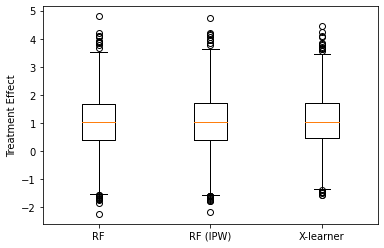

In [28]:
plt.figure()
plt.boxplot([rf_te_test, rf_ipsw_te_test, xl_te_test.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

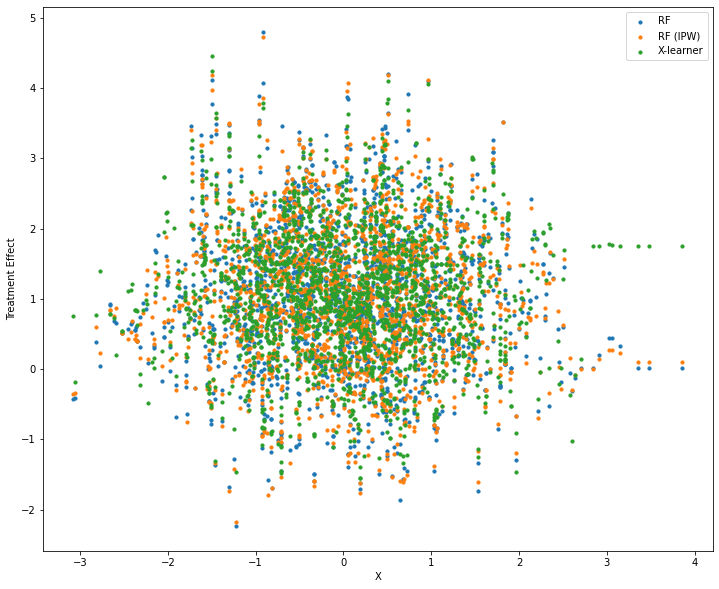

In [29]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test, rf_te_test, label="RF", s=m_size)
plt.scatter(x_test, rf_ipsw_te_test, label="RF (IPW)", s=m_size)
plt.scatter(x_test, xl_te_test, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

******